In [1]:
from sympy import *
import collections
import itertools
init_printing()

In [2]:
a,b = symbols('a b')
KroneckerDelta(a,b)

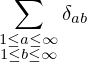

In [3]:
Sum(Sum(KroneckerDelta(a,b),(a,1,oo)),(b,1,oo))

In [4]:
class Compartment(Function):
    nargs = 1

    def __str__(self):
        return f'[{self.args[0]}]'

    def _sympystr(self, printer=None):
        return f'[{self.args[0]}]'

    def _latex(self, printer=None):
        return '\\left[' + printer.doprint(self.args[0]) + '\\right]'


class ContentChange(Function):
    nargs = 2

    def __str__(self):
        return f'{self.args}'

    def _sympystr(self, printer=None):
        return f'{self.args}'

    def _latex(self, printer=None):
        return printer.doprint(self.args)


class Context:

    def __init__(self, numSpecies: int):
        self.D = numSpecies
        self.gamma = IndexedBase('\gamma', integer=True, shape=self.D)
        self.numCompartments = Function('n', integer=True)

    def compartment(self, *args):
        return Compartment(*args)

    def change(self, *args):
        return ContentChange(*args)

    def n(self, content):
        if content.func == Compartment:
            return self.n(content.args[0])
#         return self.numCompartments(content)
        return self.numCompartments(*self.__getContentPerSpecies(content))

    def kronecker(self, content1, content2):
        if content1.func == Compartment:
            return self.kronecker(content1.args[0], content2)
        if content2.func == Compartment:
            return self.kronecker(content1, content2.args[0])
        return KroneckerDelta(content1, content2)

    def __str__(self):
        return f'Context({self.D})'


    def doit(self, transition, propensity):
        delta_m = self.deltaM(transition)
        content_variables = self.getContentVariables(transition)
        mass_action = self.getMassAction(transition)

        print("deltaM:")
        display(delta_m)
        print("content variables:")
        display(content_variables)
        print("mass action:")
        display(mass_action)

        (kC, gC, pC) = propensity
        expr = kC * delta_m * gC * mass_action * pC
        for X in content_variables:
            for i in range(self.D):
                expr = Sum(expr,(X[i],0,oo))
        display(expr)
        return expr

    
    
    def getMoment(self, content, *gamma):
        if len(gamma) != self.D:
            raise RuntimeError(f'expected {self.D} arguments.')
        expr = self.__getGamma(content).subs({self.gamma[i]:gamma[i] for i in range(self.D)})
        expr *= self.n(content)
        for i in range(self.D):
            expr = Sum(expr,(content[i],0,oo))
        return expr
    



    # We can handle [x], n*[x], and [x] + [y]
    # where n is an integer, and x, y are compartment content variables
    def getMassAction(self, transition):
        expr = transition.lhs
        if expr.func == Add:
            summands = [*expr.args]
        else:
            summands = [expr]
        # print(f'summands={summands}')

        compartments = collections.defaultdict(int)
        for expr in summands:
            # print(f'expr = {expr}')
            if expr.func == Mul and expr.args[ 0 ].func == Integer and expr.args[ 1 ].func == Compartment:
                count = expr.args[0]
                compartment = expr.args[1]
            elif expr.func == Compartment:
                count = 1
                compartment = expr
            elif expr.func == EmptySet:
                continue
            compartments[compartment] += count
        # for (compartment, count) in compartments.items():
        #     print(f'{count} * [{compartment.args[0]}]')

        if len(compartments) == 0:
            return 1
        elif len(compartments) == 1:
            (compartment, count) = next(iter(compartments.items()))
            self.__checkSimpleCompartment(compartment)
            return 1 / factorial(count) * ff(self.n(compartment), count)
        elif len(compartments) == 2:
            i = iter(compartments.items())
            (compartment1, count1) = next(i)
            (compartment2, count2) = next(i)
            self.__checkSimpleCompartment(compartment1)
            self.__checkSimpleCompartment(compartment2)
            if count1 != 1 or count2 != 1:
                raise RuntimeError("Higher than 2nd order transitions are not implemented yet")
            return self.n(compartment1) * (self.n(compartment2) - self.kronecker(compartment1, compartment2))
        else:
            raise RuntimeError("Higher than 2nd order transitions are not implemented yet")

    def __checkSimpleCompartment(self, expr):
        """Checks that expr is a Compartment(IndexedBase) and throws TypeError if it is not"""
        if not (expr.func == Compartment and len(expr.args) == 1 and expr.args[0].func == IndexedBase):
            raise TypeError(
                "Only compartments comprising a singe content variable are supported (not '" + str(expr) + "')")



    def getContentVariables(self, transition):
        """Get set of all content variables occuring in transition"""
        input = [transition.lhs, transition.rhs]
        output = []
        while input:
            expr = input.pop()
            if expr.func == Compartment:
                content = expr.args[ 0 ]
                output += self.__getContentVariables(content)
            elif expr.func == Add or expr.func == Mul:
                input += expr.args
            elif expr.func == EmptySet or expr.func == Integer:
                continue
            else:
                raise TypeError( "Unexpected expression " + str(expr))
        return list(set(output))

    def __getContentVariables(self, content):
        if content.func == Add or content.func == Mul:
            xs = [self.__getContentVariables(arg) for arg in content.args]
            return list(itertools.chain(*xs))
        elif content.func == ContentChange or issubclass(content.func, Integer):
            return []
        elif content.func == IndexedBase:
            return [content]
        else:
            raise TypeError( "Unexpected expression " + str(content))



    def deltaM(self, transition):
        """Get $\Delta\mathcal{M}[\gamma]_{transition}$"""
        return self.__deltaMExpr(transition.rhs) - self.__deltaMExpr(transition.lhs)

    def __deltaMExpr(self, expr):
        if expr.func == Compartment:
            content = expr.args[ 0 ]
            species = self.__getContentPerSpecies(content);
            return self.__getGamma(species)
        elif expr.func == EmptySet:
            return 0
        elif expr.func == Integer:
            return expr
        elif expr.func == Add:
            return Add(*[self.__deltaMExpr(i) for i in expr.args])
        elif expr.func == Mul:
            return Mul(*[self.__deltaMExpr(i) for i in expr.args])
        else:
            raise TypeError( "Unexpected expression " + str(expr))

    def __getContentPerSpecies(self, content):
        """Get an array of scalars representing compartment content for species 0..D"""
        if content.func == Add:
            xs = [self.__getContentPerSpecies(arg) for arg in content.args]
            return [Add(*x) for x in zip(*xs)]
        elif content.func == Mul:
            xs = [self.__getContentPerSpecies(arg) for arg in content.args]
            return [Mul(*x) for x in zip(*xs)]
        elif content.func == IndexedBase:
            return [content[i] for i in range(self.D)]
        elif content.func == ContentChange:
            return [content.args[i] for i in range(self.D)]
        elif issubclass(content.func, Integer):
            return [content] * self.D
        else:
            raise TypeError("Unexpected expression " + str(content))

    def __getGamma(self, content):
        return Mul(*[content[i] ** self.gamma[i] for i in range(self.D)])



class Transition(Basic):
    def __init__(self, lhs, rhs):
        self.lhs = lhs
        self.rhs = rhs

    def __str__(self):
        return f'{self.lhs} ---> {self.rhs})'

    def _latex(self, printer=None):
        # Always use printer.doprint() otherwise nested expressions won't
        # work. See the example of ModOpWrong.
        l = printer.doprint(self.lhs)
        r = printer.doprint(self.rhs)
        return l + '\longrightarrow{}' + r

In [5]:
C = Context(2)

X = IndexedBase('X', integer=True, shape=C.D)
Y = IndexedBase('Y', integer=True, shape=C.D)

print()

Exit = Transition(C.compartment(2*X + C.change(1,2)), EmptySet())
display(Exit)

[(1, 2) + 2*X] ---> EmptySet())

[X] ---> EmptySet())

deltaM:


content variables:


mass action:


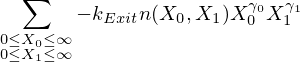

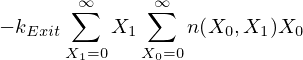

In [6]:
Exit = Transition(C.compartment(X), EmptySet())
kExit = symbols('k_{Exit}')
gExit = 1
piExit = 1
display(Exit)
expr = C.doit(Exit, (kExit, gExit, piExit))


subs = expr.subs({C.gamma[0]:1, C.gamma[1]:1})
simp = combsimp(subs)
simp

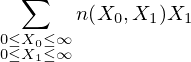

In [20]:
m01 = C.getMoment(X,0,1)
m01

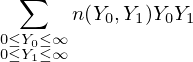

In [7]:
m11 = C.getMoment(Y,1,1)
m11

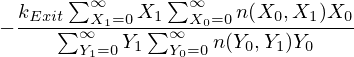

In [8]:
cancel(simp/combsimp(m11))